In [86]:
import scipy.io as sio
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [126]:
P300_result=np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','1','2','3','4','5','6','7','8','9','0']).reshape(6,6)
P300_Result=pd.DataFrame([P300_result][0])

In [127]:
Data=[]

for i in range(8):
    label_indexs=[]
    file='A0'+str(i+1)+'.mat'
    A0X = sio.loadmat(file,squeeze_me=True)
    df=pd.DataFrame(A0X['data']['X'].tolist(),columns=A0X['data']['channels'].tolist().tolist())
    df['y_stim']=A0X['data']['y_stim'].tolist().tolist()
    df['P300']=A0X['data']['y'].tolist().tolist()
    active_indexs=df[df.y_stim!=0].index.tolist()[::32]
    target_x,notarget_x=[],[]
    order_input,col_and_rows,ground_true=[],[],[]
    begin_index,end_index=40,120
    #sub_sample=20
    #sub_sample_index=int((end_index-begin_index)/20)
    for index in active_indexs:
        values=df.iloc[index+begin_index:index+end_index,:8].values
        values=(values-np.mean(values,axis=0))[np.newaxis]
        #values=signal.filtfilt(b, a, values,axis=0)[np.newaxis,::sub_sample_index]
        order_input.append(values)
        col_and_rows.append(df.iloc[index].y_stim)
        if df.iloc[index]['P300']==1:
            notarget_x.append(values)
            label_indexs.append(0)
        else:
            target_x.append(values)
            label_indexs.append(1)
            ground_true.append(df.iloc[index].y_stim)
    notarget_x=np.concatenate(notarget_x,axis=0)
    target_x=np.concatenate(target_x,axis=0)
    order_input=np.concatenate(order_input,axis=0)
    col_and_rows=np.array(col_and_rows)
    ground_true=np.array(ground_true)
    ground_col_and_rows=ground_true.reshape(-1,2).astype(int)
    P300_Result.index=np.arange(1,7)
    P300_Result.columns=np.arange(7,13)
    Ground_true=[ P300_Result[y][x] for (x,y) in ground_col_and_rows.tolist()]
    order_input=order_input.reshape(len(order_input),-1)
    Data.append([label_indexs,order_input.reshape(len(order_input),-1)])

In [128]:
order_output=[]
acc_train=[[] for x in range(8)]
acc_test=[[] for x in range(8)]
models=[[] for x in range(8)]
for user in range(8):
    print(user)
    X_train, X_test, y_train, y_test = Data[user][1][:25*10*12], Data[user][1][25*10*12:],Data[user][0][:25*10*12], Data[user][0][25*10*12:]
    h = .02  # step size in the mesh
#     names = ["Linear Discriminant Analysis","Nearest Neighbors", "Linear SVM", "RBF SVM",
#              "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#              "Naive Bayes"]
#     classifiers = [
#         LinearDiscriminantAnalysis(),
#         KNeighborsClassifier(3),
#         SVC(kernel="linear", C=0.025),
#         SVC(gamma=2, C=1),
#         DecisionTreeClassifier(max_depth=5),
#         RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#         MLPClassifier(alpha=1, max_iter=500),
#         AdaBoostClassifier(),
#         GaussianNB(),]
    classifiers=[LinearDiscriminantAnalysis()]
    names=["Linear Discriminant Analysis"]
    acc,classifier=[],[]
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        models[user].append(clf)
        Train_pred=clf.predict(X_train)
        Test_pred=clf.predict(X_test)
        confusion=confusion_matrix(y_train,Train_pred)/np.sum(confusion_matrix(y_train,Train_pred))
        print('model:%s  train accuarcy: %.2f'%(name,np.sum(np.diag(confusion))))
        acc_train[user].append(np.sum(np.diag(confusion)))
        confusion=confusion_matrix(y_test,Test_pred)/np.sum(confusion_matrix(y_test,Test_pred))
        acc_test[user].append(np.sum(np.diag(confusion)))
        print('model:%s  test accuarcy: %.2f'%(name,np.sum(np.diag(confusion))))

0
model:Linear Discriminant Analysis  train accuarcy: 0.87
model:Linear Discriminant Analysis  test accuarcy: 0.83
1
model:Linear Discriminant Analysis  train accuarcy: 0.88
model:Linear Discriminant Analysis  test accuarcy: 0.84
2
model:Linear Discriminant Analysis  train accuarcy: 0.90
model:Linear Discriminant Analysis  test accuarcy: 0.83
3
model:Linear Discriminant Analysis  train accuarcy: 0.87
model:Linear Discriminant Analysis  test accuarcy: 0.82
4
model:Linear Discriminant Analysis  train accuarcy: 0.88
model:Linear Discriminant Analysis  test accuarcy: 0.82
5
model:Linear Discriminant Analysis  train accuarcy: 0.90
model:Linear Discriminant Analysis  test accuarcy: 0.84
6
model:Linear Discriminant Analysis  train accuarcy: 0.89
model:Linear Discriminant Analysis  test accuarcy: 0.88
7
model:Linear Discriminant Analysis  train accuarcy: 0.92
model:Linear Discriminant Analysis  test accuarcy: 0.89


In [130]:
diff_=[]
label_index=np.load('label_indexs.npy')
for i in range(8):
    p300_index=np.unique(np.arange(4200)*label_index)[1:]
    nop300_index=np.unique(np.arange(4200)*(1-label_index))
    nop300=Data[i][1][nop300_index].reshape(-1,10,80,8)
    p300=Data[i][1][p300_index].reshape(-1,2,80,8)
    diff=[]
    for i in range(p300.shape[0]):
        p300_signal=p300[i]
        nop300_signal=nop300[i]
        for v in range(2):
            x=np.mean(p300_signal[v]-p300_signal[v,0],axis=0)
            y=np.mean(nop300_signal[v]-nop300_signal[v,0],axis=0)
            diff.append(np.abs(x-y)[np.newaxis])
    diff=np.concatenate(diff)
    diff_.append(diff)

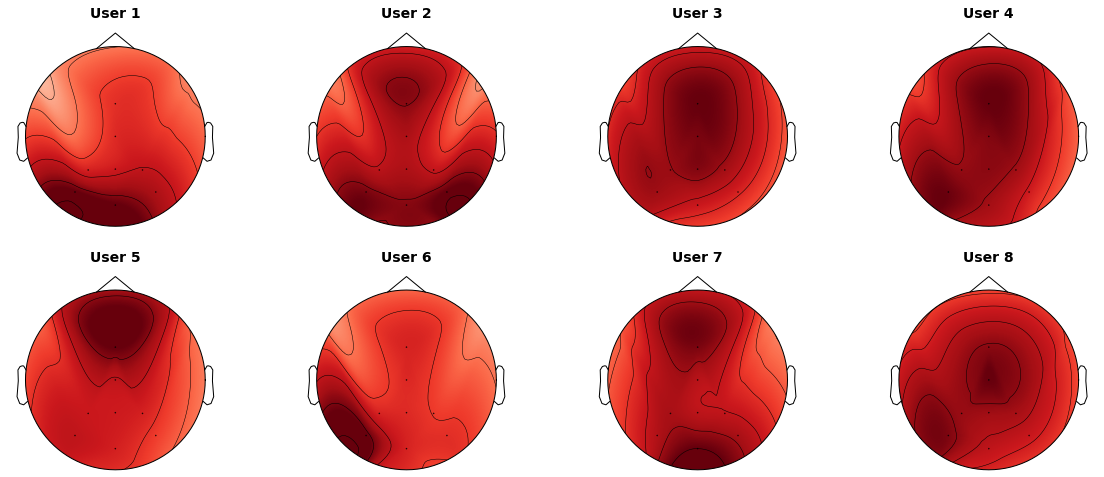

In [131]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

#设置通道名
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
#生成数据
data = np.mean(diff,axis=0).reshape(-1,1)
#创建info对象
info = mne.create_info(ch_names= A0X['data']['channels'].tolist().tolist(), sfreq=256.,
                            ch_types='eeg')
#创建evokeds对象                       
evoked = mne.EvokedArray(data, info)
#evokeds设置通道
evoked.set_montage(biosemi_montage)

# add titles
for i in range(8):
    x,y=int(i/4),i%4
    names='User '+str(i+1)
    mne.viz.plot_topomap(np.mean(diff_[i],axis=0), evoked.info, axes=ax[x,y],show=False)
    ax[x,y].set_title(names, fontweight='bold',fontsize=14)

In [133]:
for user in range(8):
    order_output=models[user][0].predict(Data[user][1])
    order_output=order_output.reshape(-1,120)
    pred=pd.DataFrame(order_output,columns=col_and_rows.reshape(-1,120)[0].astype(int))
    votting=[]
    for i in range(pred.shape[0]):
        vot=[[] for x in range(12)]
        for x in range(12):vot[x]=0
        #print(pred.iloc[i].values)
        for x,y in zip(pred.iloc[i].values,pred.iloc[i].index):
            if x==1:vot[y-1]+=1
        votting.append(vot)
    votting=pd.DataFrame(votting)
    rows,cols=np.argmax(votting.values[:,:6],axis=1).tolist(),np.argmax(votting.values[:,6:],axis=1).tolist()
    count,prediction=0,[]
    for x,y,labels in zip(rows,cols,Ground_true[::10]):
        if P300_Result[y+7][x+1]==labels:count+=1
        #print(P300_Result[y+7][x+1])
        prediction.append(P300_Result[y+7][x+1])
    confusion=confusion_matrix(prediction,Ground_true[::10])\
    /np.sum(confusion_matrix(prediction,Ground_true[::10]))
    #test = pd.DataFrame(confusion,columns=set(Ground_true[::10]),index=set(Ground_true[::10]))
    print(np.sum(np.diag(test)))

0.05714285714285714
0.05714285714285714
0.05714285714285714
0.05714285714285714
0.05714285714285714
0.05714285714285714
0.05714285714285714
0.05714285714285714


In [135]:
Ground_true

['2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A'

In [ ]:
pd.DataFrame(votting)

<AxesSubplot:>

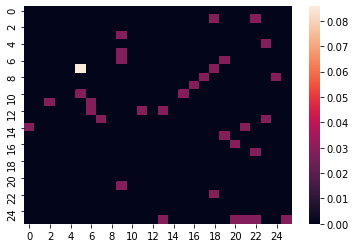

In [96]:
sns.heatmap(confusion)

In [104]:
Data[user][3].shape

(4200, 640)

In [83]:
len(set(Ground_true[::10]))

19

In [98]:
Ground_true

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'R',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'Z',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'P',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A'